In [1]:
# import and set up packages
from pathlib import Path

import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import flowers
import ard
import floris

plt.style.use(ard.get_house_style(use_tex=True))

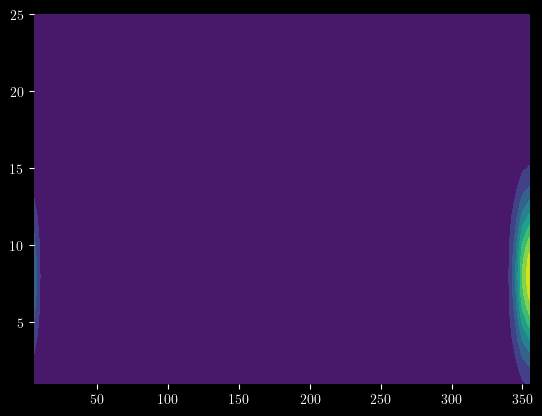

In [2]:
# create wraparound gaussian pulse resource for nearly single-directional wind
def f_windrose(wd_center, ws_center, wd_width=10.0, ws_width=5.0):
    wd_raw = np.arange(0.0, 360.0, 5.0)[1:]
    ws_raw = np.arange(0.0, 25.001, 1.0)[1:]
    WS, WD = np.meshgrid(ws_raw, wd_raw)
    FREQ = (np.exp(-(((WS - ws_center) / ws_width) ** 2))) * (
        np.exp(-(((WD - wd_center - 720.0) / wd_width) ** 2))
        + np.exp(-(((WD - wd_center - 360.0) / wd_width) ** 2))
        + np.exp(-(((WD - wd_center + 0.0) / wd_width) ** 2))
        + np.exp(-(((WD - wd_center + 360.0) / wd_width) ** 2))
        + np.exp(-(((WD - wd_center + 720.0) / wd_width) ** 2))
    )
    FREQ = np.maximum(FREQ, 0.001)
    FREQ /= np.sum(FREQ)
    df_wr = pd.DataFrame(
        {
            "wd": WD.flat,
            "ws": WS.flat,
            "freq_val": FREQ.flat,
        }
    )
    return (WD, WS, FREQ), df_wr


(WD, WS, FREQ), df_wr = f_windrose(-5.0, 8.0)
plt.contourf(WD, WS, FREQ)

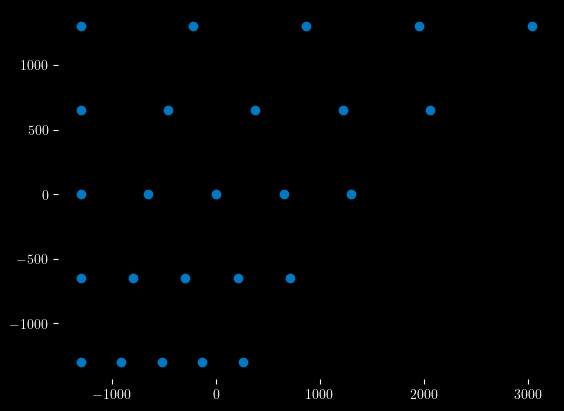

In [3]:
# generate the layout generator w/o rotational symmetries
def layout_generator(
    diameter=1.0,
    orientation=0.0,
    factor=10 / 6,
    spacing_base=5.0,
    smash_over=True,
):
    spacing_index_x = spacing_base * np.arange(-2, 2.1)
    spacing_index_y = spacing_base * np.arange(-2, 2.1)
    max_idx = np.max(np.abs(spacing_index_y))
    x_out_list = []
    y_out_list = []
    for idx in spacing_index_y:
        here_factor = factor ** (idx / max_idx)
        x_candidate = here_factor * spacing_index_x
        if smash_over:
            x_candidate = x_candidate - np.min(x_candidate)
            x_candidate = x_candidate + np.min(spacing_index_x)
        x_out_list.append(x_candidate)
        y_out_list.append(idx * np.ones_like(spacing_index_x))

    X_pre = diameter * np.array(x_out_list).flatten()
    Y_pre = diameter * np.array(y_out_list).flatten()

    X_post, Y_post = np.array(
        [
            [np.cos(np.radians(orientation)), np.sin(np.radians(orientation))],
            [-np.sin(np.radians(orientation)), np.cos(np.radians(orientation))],
        ]
    ) @ np.vstack([X_pre, Y_pre])

    return X_post, Y_post


plt.scatter(*[v.flat for v in layout_generator(diameter=130.0, orientation=0.0)])

In [4]:
# configuration settings
path_floris_config = Path.cwd() / "precooked.yaml"

In [5]:
# set up the aerodynamic models and call functions

floris_model = floris.FlorisModel(path_floris_config)


def run_floris(wd_val=0.0, orientation=0.0):
    WD, WS, FREQ = f_windrose(
        wd_center=wd_val,
        ws_center=8.0,
    )[0]
    wind_rose = floris.wind_data.WindRose(
        wind_directions=WD[:, 0],
        wind_speeds=WS[0, :],
        ti_table=0.06,
        freq_table=FREQ,
    )

    X, Y = layout_generator(D_rotor, orientation)
    floris_model.set(
        wind_data=wind_rose,
        layout_x=X.flatten(),
        layout_y=Y.flatten(),
    )
    floris_model.run()
    return floris_model.get_farm_AEP() / 1e9  # report in GWh


turbine_def = floris_model.core.farm.turbine_definitions[0]
D_rotor = turbine_def["rotor_diameter"]
# extract variables for FLOWERS
# power curves
u_cp = u_ct = np.array(turbine_def["power_thrust_table"]["wind_speed"][1:])
cp = (
    np.array(turbine_def["power_thrust_table"]["power"][1:])
    * 1e3
    / (
        0.5
        * turbine_def["power_thrust_table"]["ref_air_density"]
        * (np.pi * D_rotor**2 / 4)
        * u_cp**3
    )
)
ct = np.array(turbine_def["power_thrust_table"]["thrust_coefficient"][1:])
# detect cutin and cutout
U_cutin = float(
    u_cp[
        np.squeeze(
            np.argwhere(
                np.isclose(cp, 0.0) & (np.array(list(range(len(cp)))) < len(cp) / 2)
            )[0]
        )
        + 1
    ]
)
U_cutout = float(
    u_cp[
        np.squeeze(
            np.argwhere(
                np.isclose(cp, 0.0) & (np.array(list(range(len(cp)))) > len(cp) / 2)
            )[0]
        )
        - 1
    ]
)
print(f"detected cut in {U_cutin} and cut out {U_cutout}. verify.")


# set up flowers model
def run_FLOWERS(wd_val=0.0, orientation=0.0):
    X, Y = layout_generator(D_rotor, orientation)

    fm = flowers.FlowersModel(
        wind_rose=f_windrose(
            wd_center=wd_val,
            ws_center=8.0,
        )[1],
        layout_x=X,
        layout_y=Y,
        turbine={
            "D": D_rotor,
            "cp": cp,
            "u_cp": u_cp,
            "ct": ct,
            "u_ct": u_ct,
            "U": U_cutout,
        },
    )

    return fm.calculate_aep() / 1e9  # return in GWh

floris.floris_model.FlorisModel WARNING The only unique hub-height is not equal to the specified reference wind height. If this was unintended use -1 as the reference hub height to indicate use of hub-height as reference wind height.


detected cut in 3.0 and cut out 25.0. verify.


In [6]:
# run an experiment: move the pulse wind resource around the compass
wd_vec = np.arange(0.0, 360.001, 1.0)
AEP_FLOWERS_vec = np.zeros_like(wd_vec)
AEP_FLORIS_vec = np.zeros_like(wd_vec)
for idx, wd_val in enumerate(tqdm.tqdm(wd_vec)):
    AEP_FLOWERS_vec[idx] = run_FLOWERS(wd_val=wd_val)
    AEP_FLORIS_vec[idx] = run_floris(wd_val=wd_val)

100%|██████████| 361/361 [16:14<00:00,  2.70s/it]


Text(0.5, 0, 'percent difference in FLOWERS w.r.t. FLORIS, (\\%)')

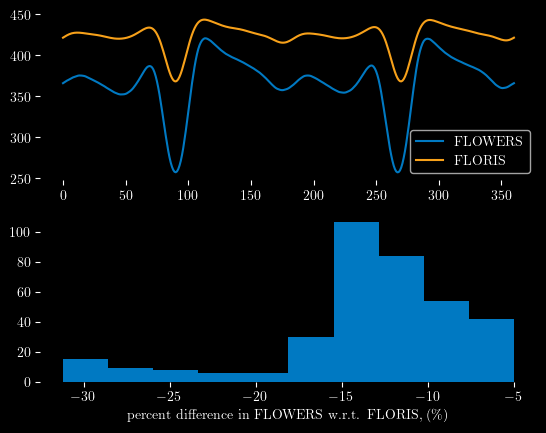

In [7]:
# plot the results of the experiment
fig, axes = plt.subplots(2, 1)
axes[0].plot(wd_vec, AEP_FLOWERS_vec, label="FLOWERS")
axes[0].plot(wd_vec, AEP_FLORIS_vec, label="FLORIS")
axes[0].legend()
axes[1].hist((AEP_FLOWERS_vec - AEP_FLORIS_vec) / AEP_FLORIS_vec * 100)
axes[1].set_xlabel("percent difference in FLOWERS w.r.t. FLORIS, (\\%)")

In [9]:
# run an experiment: move the pulse wind resource around the compass
orientation_vec = np.arange(0.0, 360.001, 1.0)
AEP_FLOWERS_vec = np.zeros_like(orientation_vec)
AEP_FLORIS_vec = np.zeros_like(orientation_vec)
for idx, orientation_val in enumerate(tqdm.tqdm(orientation_vec)):
    AEP_FLOWERS_vec[idx] = run_FLOWERS(orientation=orientation_val)
    AEP_FLORIS_vec[idx] = run_floris(orientation=orientation_val)

100%|██████████| 361/361 [14:35<00:00,  2.43s/it]


Text(0.5, 0, 'percent difference in FLOWERS w.r.t. FLORIS, (\\%)')

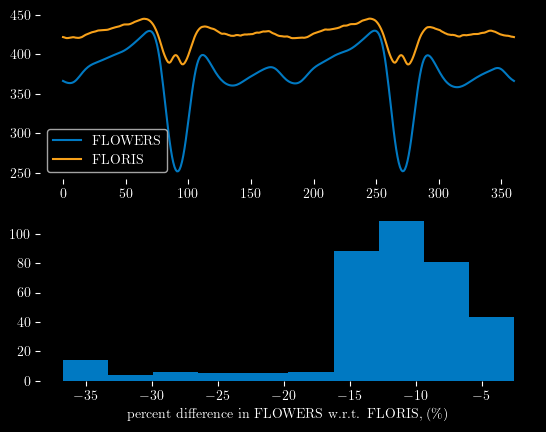

In [10]:
# plot the results of the experiment
fig, axes = plt.subplots(2, 1)
axes[0].plot(orientation_vec, AEP_FLOWERS_vec, label="FLOWERS")
axes[0].plot(orientation_vec, AEP_FLORIS_vec, label="FLORIS")
axes[0].legend()
axes[1].hist((AEP_FLOWERS_vec - AEP_FLORIS_vec) / AEP_FLORIS_vec * 100)
axes[1].set_xlabel("percent difference in FLOWERS w.r.t. FLORIS, (\\%)")